<a href="https://colab.research.google.com/github/citruscaesar/building-footprint-extraction/blob/main/evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%capture
%pip install rasterio
%pip install lightning
%pip install segmentation-models-pytorch
%pip install torchmetrics
%pip install patchify

In [ ]:
!git clone https://github.com/citruscaesar/building-footprint-extraction.git
!cp -r ./building-footprint-extraction/src/ ./ 
!rm -r ./building-footprint-extraction

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
%mkdir -p ./inria/train/images
%mkdir -p ./inria/train/gt
!cp ./drive/MyDrive/

In [1]:
from pathlib import Path
import numpy as np
import rasterio as rio
import matplotlib.pyplot as plt

import torch
from torchvision import transforms
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.encoders import get_preprocessing_fn

from patchify import patchify, unpatchify

from src.datamodule import InriaDataset, InriaDataModule
from src.lightningmodule import SegmentationModule

from torchmetrics import MetricCollection
from torchmetrics.classification import BinaryJaccardIndex, BinaryF1Score, BinaryAccuracy

In [2]:
#INRIA = Path.cwd() / "drive" / "MyDrive"/ "datasets" / "inria" / "AerialImageDataset"
INRIA = Path.cwd().parent / "datasets" / "inria"
SCENES = INRIA / "train" / "images"
MASKS = INRIA / "train" / "gt"
PREDS = INRIA / "predictions"
PREDS.mkdir(exist_ok=True)
CHECKPOINTS = INRIA.parent / "checkpoints"

In [3]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)

cuda


### Load Model

In [4]:
checkpoint_path = next(CHECKPOINTS.iterdir())
checkpoint = torch.load(checkpoint_path)
unet = smp.Unet("resnet18") 
preprocess = get_preprocessing_fn("resnet18")
model = SegmentationModule(unet,
                           loss = "dice",
                           learning_rate = 3e-4,
                           batch_size = 4)
model.load_state_dict(checkpoint["state_dict"])

<All keys matched successfully>

In [5]:
def load_raster_and_profile(raster_path):
    with rio.open(raster_path) as raster:
        return torch.from_numpy(raster.read()), raster.profile

### Idea 1: Inference on Entire Scene

#### Padded Input, Cropped Output

In [6]:
IMG_SIDE = 5000
TARGET_IMG_SIDE = (IMG_SIDE//32 + 1) * 32
PAD_MARGIN = (TARGET_IMG_SIDE - IMG_SIDE)//2
pad = transforms.Pad(padding=PAD_MARGIN)
unpad = transforms.CenterCrop(IMG_SIDE)
pad_down = transforms.Resize(2048)
unpad_down = transforms.CenterCrop(2048)
#resize_up = transforms.Resize(target_IMG_SIDE, antialias = True)

In [7]:
scene_locations = ["austin", "chicago", "kitsap", "tyrol-w", "vienna"]
eval_names = [f"{loc}{idx}.tif" for idx in range(1, 6) for loc in scene_locations]
scene_paths = [SCENES/x for x in eval_names]
mask_paths = [MASKS/x for x in eval_names]

uint8
(1, 2048, 2048)
{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': None, 'width': 5000, 'height': 5000, 'count': 1, 'crs': CRS.from_epsg(26914), 'transform': Affine(0.3, 0.0, 616500.0,
       0.0, -0.3, 3345000.0), 'tiled': False, 'compress': 'lzw', 'interleave': 'band'}


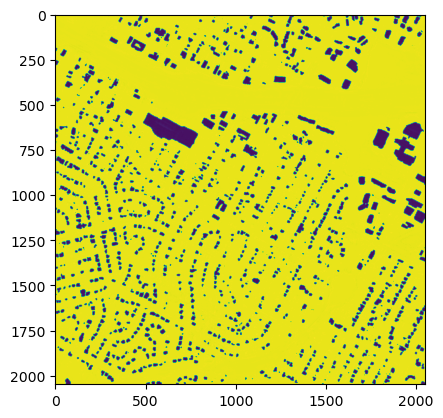

In [8]:
for (scene_path, mask_path) in zip(scene_paths, mask_paths):
    scene, scene_profile = load_raster_and_profile(scene_path)
    _, mask_profile = load_raster_and_profile(mask_path)

    scene = pad_down(scene.float() / 255.).to(DEVICE)
    #mask = pad_down(torch.clip(mask, 0., 1.)).to(DEVICE)

    #scene = resize_down(scene)
    scene = scene.unsqueeze(dim = 0)

    model.to(DEVICE)
    model.eval()
    with torch.no_grad():
        pred_mask = model.forward(scene)


    pred_mask = pred_mask.squeeze(dim = 0)
    pred_mask = unpad_down(pred_mask)
    #Calculate Metrics, if needed, while on GPU
    #
    #

    pred_mask = pred_mask.cpu().numpy()
    pred_mask = pred_mask.astype('uint8', copy = False) 
    with rio.open(PREDS/scene_path.name, mode = 'w', **mask_profile) as pred:
        pred.write(pred_mask) 
    plt.imshow(pred_mask.transpose(1, 2, 0))

    print(pred_mask.dtype)
    print(pred_mask.shape)
    print(mask_profile)
    #break

In [13]:
import shutil

loc = "austin1.tif"
scene_path = SCENES / loc
mask_path = MASKS / loc 

dest_scene_path = Path.cwd() / "inria" / "train" / "images" / loc
dest_mask_path = Path.cwd() / "inria" / "train" / "gt" / loc

shutil.copy(scene_path, dest_scene_path)
shutil.copy(mask_path, dest_mask_path)

FileNotFoundError: [Errno 2] No such file or directory: 'c:\\Users\\Sambhav Chandra\\dev\\building-footprint-extraction\\inria\\train\\images\\austin1.tif'

In [ ]:
scene = torch.from_numpy(load_raster(dest_scene_path)).to(torch.float)
mask = torch.from_numpy(load_raster(dest_mask_path)).to(torch.float)

In [ ]:
size = ((5000//32) + 1) * 32
#size = 2048 
scale_up = transforms.Resize(size = (size, size))
scale_down = transforms.Resize(size = (5000, 5000))

In [ ]:
scene /= 255.
scene = scale_up(scene)
scene = scene.unsqueeze(dim = 0).to(DEVICE)

mask = mask.clip(0, 1).float()

In [ ]:
print(scene.shape)
print(scene.device)

In [ ]:
model = model.to(DEVICE)
print(model.device)

In [ ]:
model.eval()
with torch.no_grad():
    pred_mask = model.forward(scene)
    pred_mask = scale_down(pred_mask)
    mask = mask.to(DEVICE)
    dice = BinaryF1Score().to(DEVICE)
    print(dice(pred_mask[0], mask))

In [ ]:
plt.figure(figsize = (10,10))
plt.imshow(scene[0].permute(1, 2, 0).cpu())
plt.imshow(pred_mask[0].permute(1, 2, 0).cpu(), cmap = 'jet', alpha = .3)
plt.axis("off")

### Idea 2: Inference on Non-Overlapping Patches

In [ ]:
raster_path = next(DATA.iterdir())
with rio.open(raster_path) as raster:
    scene = raster.read()

In [ ]:
fig = plt.figure(figsize = (10, 10))
plt.imshow(scene.transpose(1, 2, 0))
plt.axis("off")

In [ ]:
patches = patchify(scene.transpose(1, 2, 0), (512, 512, 3), step = 408)

In [ ]:
plt.imshow(patches.squeeze()[0, 0])

In [ ]:
plt.imshow(unpatchify(patches, imsize = (5000, 5000, 3)))


In [ ]:
BINARY_LOSS = "binary"
MULTICLASS_LOSS = "multiclass"

In [ ]:
"binary" in {BINARY_LOSS, MULTICLASS_LOSS}